ТЗ

Даны 3 датасета с информацикей о пользовании сервисом GoFast. Необходимо:
- Открыть датасеты и посмотреть их содердимое
- Провести предобработку данных, выявив и, по возможности, убрав дубли и пропуски
- Провести исследовательский анализ данных, визуализируя нужные нам показатели
- Сформулировать первые выводы на основе изученных данных
- Проверить следующие гипотезы: 


1) Тратят ли пользователи с подпиской больше времени на поездки?

2) Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

3) Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

4) Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

#### Шаг 1. Загрузка данных

In [2]:
df_users = pd.read_csv('/datasets/users_go.csv', encoding='UTF-8')
df_rides = pd.read_csv('/datasets/rides_go.csv', encoding='UTF-8')
df_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv', encoding='UTF-8')

In [3]:
print(df_users.shape)
df_users.head()

(1565, 5)


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
print(df_rides.shape)
df_rides.head()

(18068, 4)


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
print(df_subscriptions.shape)
df_subscriptions.head()

(2, 4)


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
# Информация по юзерам
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1565.0,762.633866,443.260155,1.0,378.0,762.0,1146.0,1534.0
age,1565.0,24.922045,4.553496,12.0,22.0,25.0,28.0,43.0


In [7]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [8]:
# Информация по поездкам
df_rides.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,18068.0,842.869936,434.734317,1.000000,487.000000,889.000000,1213.250000,1534.000000
distance,18068.0,3070.659976,1116.831209,0.855683,2543.226360,3133.609994,3776.222735,7211.007745
duration,18068.0,17.805011,6.091051,0.500000,13.597563,17.678395,21.724800,40.823963


In [9]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [10]:
# Информация по тарифам
df_subscriptions.describe().T

,count,mean,std,min,25%,50%,75%,max
minute_price,2.0,7.0,1.414214,6.0,6.50,7.0,7.50,8.0
start_ride_price,2.0,25.0,35.355339,0.0,12.50,25.0,37.50,50.0
subscription_fee,2.0,99.5,140.714249,0.0,49.75,99.5,149.25,199.0


In [11]:
df_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Мы имеем категориальные признаки: персональный ID пользователя, имя, город, тип подписки.

Количественные признаки: расстояние, длительность поездки, цена за минуту, цена старта, цена подписки

Также есть дата поездки

#### Шаг 2. Предобработка данных

In [12]:
df_rides['date'] = pd.to_datetime(df_rides['date'])
df_rides['month'] = df_rides['date'].dt.month
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [13]:
print(df_rides['date'].min())
print(df_rides['date'].max())

2021-01-01 00:00:00
2021-12-30 00:00:00


In [14]:
df_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [15]:
df_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Третий датафрейм нет смысла проверять на пропуски, потому что там 2 строки всего

In [16]:
# 1565 -> 1534
df_users = df_users.drop_duplicates().reset_index(drop=True)
df_users.shape

(1534, 5)

In [17]:
# Тут явных дупликатов нет (Что логично, учитывая, что таблица полностью из чисел и дат)
df_rides = df_rides.drop_duplicates().reset_index(drop=True)
df_rides.shape

(18068, 5)

Тут посмотрим на неявные дупликаты: Во-первых, на названия городов, во-вторых, на имена (на предмет производных по типу "Александр", "Саша", "Саня")

In [18]:
df_users['city'] = df_users['city'].str.lower()
df_users['city'].unique()

array(['тюмень', 'омск', 'москва', 'ростов-на-дону', 'краснодар',
       'пятигорск', 'екатеринбург', 'сочи'], dtype=object)

In [19]:
df_users['name'] = df_users['name'].str.lower()
sorted(df_users['name'].unique())

['агата',
 'аделина',
 'адель',
 'айдар',
 'александр',
 'александра',
 'алексей',
 'алина',
 'алиса',
 'алия',
 'алла',
 'альберт',
 'альбина',
 'алёна',
 'амалия',
 'амина',
 'амир',
 'анастасия',
 'анатолий',
 'ангелина',
 'андрей',
 'анжелика',
 'анна',
 'антон',
 'антонина',
 'ариана',
 'арина',
 'арсен',
 'арсений',
 'артемий',
 'артур',
 'артём',
 'богдан',
 'борис',
 'вадим',
 'валентина',
 'валерий',
 'валерия',
 'варвара',
 'василий',
 'василина',
 'василиса',
 'вера',
 'вероника',
 'виктор',
 'виктория',
 'виолетта',
 'виталий',
 'виталина',
 'влад',
 'влада',
 'владимир',
 'владислав',
 'владислава',
 'всеволод',
 'вячеслав',
 'галина',
 'георгий',
 'герман',
 'глеб',
 'гордей',
 'григорий',
 'давид',
 'дамир',
 'даниил',
 'данил',
 'данила',
 'даниэль',
 'дарина',
 'дарья',
 'демид',
 'денис',
 'диана',
 'дмитрий',
 'ева',
 'евгений',
 'евгения',
 'егор',
 'екатерина',
 'елена',
 'елизавета',
 'елисей',
 'есения',
 'жанна',
 'зарина',
 'захар',
 'злата',
 'иван',
 'игнат',

Неявных дупликатов не обнаружилось. В остальном, преобладают числовые значения, где нет смысла их искать

In [20]:
df_users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

Были проанализированы данные о поездках, пользователях сервиса аренды самокатов. Выбросов не обнаружено, неявных дубликатов тоже. Явные дубликаты были найдены и удалены из таблицы с пользователями. В датах, именах и городах аномалий и дубликтаов найдено не было

#### Шаг 3. Исследовательский анализ данных

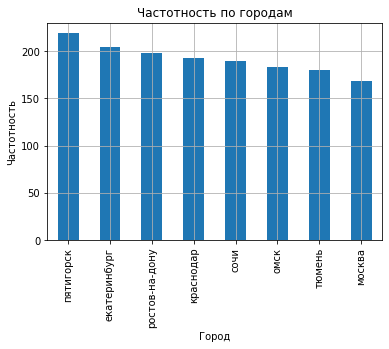

In [21]:
city_counts = df_users.groupby('city')['city'].count().sort_values(ascending=False)
city_counts.plot(kind='bar')
plt.xlabel('Город')
plt.ylabel('Частотность')
plt.title('Частотность по городам')
plt.grid(True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

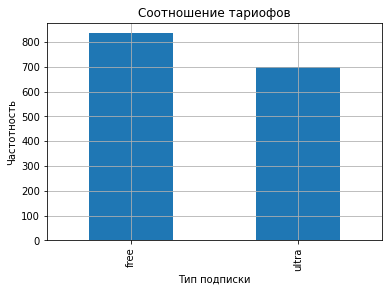

In [22]:
sub_count = df_users['subscription_type'].value_counts()
sub_count.plot(kind='bar')
plt.xlabel('Тип подписки')
plt.ylabel('Частотность')
plt.title('Соотношение тариофов')
plt.grid(True)
plt.show

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

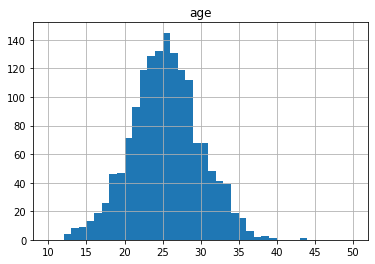

In [23]:
df_users.hist('age', bins=40, range=(10, 50), grid=True)

<AxesSubplot:>

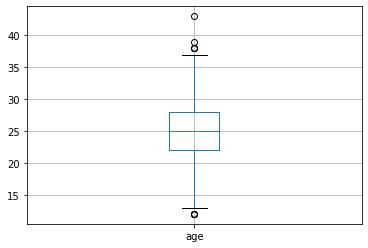

In [24]:
df_users.boxplot('age')

array([[<AxesSubplot:title={'center':'distance'}>]], dtype=object)

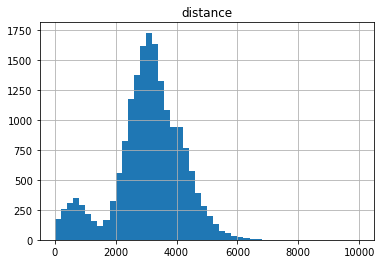

In [25]:
df_rides.hist('distance', bins=50, range=(0, 10000), grid=True)

<AxesSubplot:>

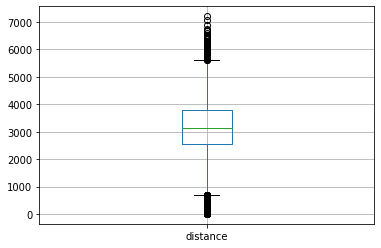

In [26]:
df_rides.boxplot('distance')

array([[<AxesSubplot:title={'center':'duration'}>]], dtype=object)

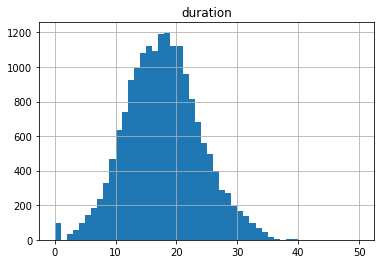

In [27]:
df_rides.hist('duration', bins=50, range=(0, 50), grid=True)

<AxesSubplot:>

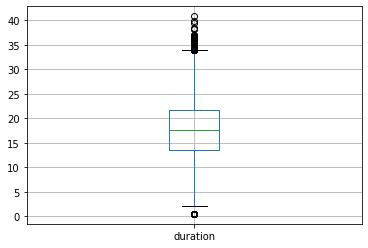

In [28]:
df_rides.boxplot('duration')

**Выводы**

1) Опираясь на данные по городам, можно предположить, что популярность самокатов, примерно, одинаковая, ведь разница между максимальным и минимальным значением около 15%. Однако, данных не так много, чтобы с уверенностью делать такой вывод.

2) Хоть спросом пользуются как сервис с подпиской, так и без, больше людей предпочитают подписку не оформлять.

3) Наиболее частыми пользователями сервиса являются люди в возрасте от 22 до 30 лет.

4) Есть небольшой рост спроса на короткие поездки до 1 км, однако больнишство арендует самокаты для поездок на расстояния 2.5 - 3.5 км.

5) Большинство поездок длятся от 12 до 22 минут.

Из времени и расстояния можно предположить, что средняя скорость самокатов около 12 км/ч, что может говорить о том, что ими пользуются в оживлённых районах города (центр, к примеру). Большое количество люедй зачастую не позволяет разгоняться больше.

#### Шаг 4. Объединение данных

In [29]:
print(df_users.shape)
print(df_rides.shape)
print(df_subscriptions.shape)

(1534, 5)
(18068, 5)
(2, 4)


In [30]:
merged_df = df_users.merge(df_rides, on='user_id').reset_index()
merged_df = merged_df.merge(df_subscriptions, on='subscription_type')
merged_df.head()

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,0,1,кира,22,тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,1,кира,22,тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,2,1,кира,22,тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,3,1,кира,22,тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,4,1,кира,22,тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [31]:
merged_df.shape

(18068, 13)

In [32]:
df_free = merged_df.loc[merged_df['subscription_type'] == 'free'].reset_index()
df_free.head()

,level_0,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,6500,6500,700,айдар,22,омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,6501,6501,700,айдар,22,омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,6502,6502,700,айдар,22,омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,6503,6503,700,айдар,22,омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,6504,6504,700,айдар,22,омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [33]:
df_ultra = merged_df.loc[merged_df['subscription_type'] == 'ultra']
df_ultra.head()

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,0,1,кира,22,тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,1,кира,22,тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,2,1,кира,22,тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,3,1,кира,22,тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,4,1,кира,22,тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


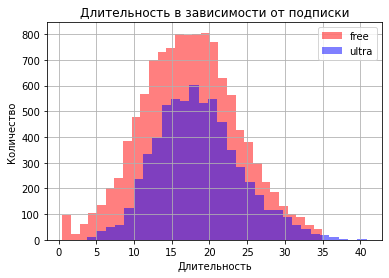

In [34]:
plt.hist(df_free['duration'], bins=30, color='red', alpha=0.5, label='Free')
plt.hist(df_ultra['duration'], bins=30, color='blue', alpha=0.5, label='Free')
plt.grid(True)
plt.xlabel('Длительность')
plt.ylabel('Количество')
plt.title('Длительность в зависимости от подписки')
plt.legend(['free', 'ultra'])
plt.show()

Предварительно, пользователи чаще пользуются бесплатным тарифом. Средняя длительность не отличается взависимости от тарифа

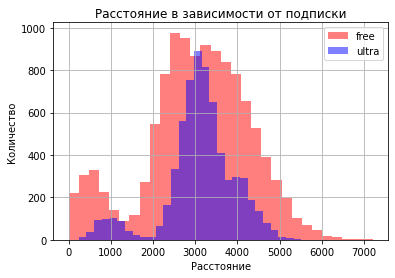

In [35]:
plt.hist(df_free['distance'], bins=30, color='red', alpha=0.5, label='Free')
plt.hist(df_ultra['distance'], bins=30, color='blue', alpha=0.5, label='Free')
plt.grid(True)
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.title('Расстояние в зависимости от подписки')
plt.legend(['free', 'ultra'])
plt.show()

Предварительно, пользователи с бесплатным тарифом чаще ездят на расстояния от 1.5 до 2.5 км и от 3.5 и выше, чем пользователи с подпиской. 

#### Шаг 5. Подсчёт выручки

In [36]:
merged_df.columns

Index(['index', 'user_id', 'name', 'age', 'city', 'subscription_type',
       'distance', 'duration', 'date', 'month', 'minute_price',
       'start_ride_price', 'subscription_fee'],
      dtype='object')

In [37]:
merged_df['duration'] = np.ceil(merged_df['duration']).astype('int64')
aggregated_df = merged_df.groupby(['user_id', 'month']).agg({
    'distance':'sum',
    'duration':'sum',
    'date':'count'
})

aggregated_df.head()

distance  duration  date
user_id month                             
1       1      7027.511294        42     2
        4       754.159807         7     1
        8      6723.470560        46     2
        10     5809.911100        32     2
        11     7003.499363        56     3

In [38]:
pivot_df = merged_df.groupby(['user_id', 'month']).agg({
    'distance': 'sum',
    'duration': 'sum',
    'date': 'count'
}).reset_index()

revenue_df = merged_df.groupby(['user_id', 'month']).agg({
    'duration': 'sum',
    'minute_price': 'first',
    'start_ride_price': 'first',
    'subscription_fee': 'first'
}).reset_index()

revenue_df['subscription_type'] = merged_df['subscription_type']

revenue_df['ride_cost'] = np.where(
    revenue_df['subscription_type'] == 'ultra',
    revenue_df['duration'] * revenue_df['minute_price'] + revenue_df['start_ride_price'] + revenue_df['subscription_fee'],
    revenue_df['duration'] * revenue_df['minute_price'] + revenue_df['start_ride_price']
)

ride_count_df = merged_df.groupby(['user_id', 'month']).size().reset_index(name='ride_count')

pivot_df = pivot_df.merge(revenue_df[['user_id', 'month', 'ride_cost', 'subscription_type']], on=['user_id', 'month'], how='left')
pivot_df = pivot_df.merge(ride_count_df, on=['user_id', 'month'], how='left')
pivot_df.rename(columns={'ride_cost': 'monthly_revenue'}, inplace=True)

pivot_df = pivot_df[['user_id', 'month', 'distance', 'duration', 'ride_count', 'monthly_revenue', 'subscription_type']]
pivot_df.sort_values(by=['user_id', 'month'], inplace=True)

pivot_df.head()

,user_id,month,distance,duration,ride_count,monthly_revenue,subscription_type
0,1,1,7027.511294,42,2,451,ultra
1,1,4,754.159807,7,1,241,ultra
2,1,8,6723.470560,46,2,475,ultra
3,1,10,5809.911100,32,2,391,ultra
4,1,11,7003.499363,56,3,535,ultra


#### Шаг 6. Проверка гипотез

Выше я уже делал график распределения длительности поездок пользователей с подпиской и без, но стоит понимать, что размер выборок может быть разный

In [39]:
df_free.head()

,level_0,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,6500,6500,700,айдар,22,омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,6501,6501,700,айдар,22,омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,6502,6502,700,айдар,22,омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,6503,6503,700,айдар,22,омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,6504,6504,700,айдар,22,омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [40]:
print(len(df_free['user_id']))
# Здесь данных почти в 2 раза больше, значит, возьму выборку отсюда в 6500 значений
df_free_random = df_free.sample(n=6500, random_state=42)
print(len(df_free_random['user_id']))

11568
6500


In [41]:
df_ultra.head()

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,0,1,кира,22,тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,1,кира,22,тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,2,1,кира,22,тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,3,1,кира,22,тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,4,1,кира,22,тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [42]:
len(df_ultra['user_id'])

6500

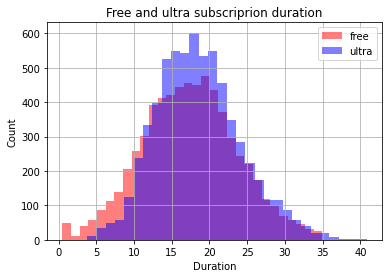

In [43]:
# График распределения длительности для пользователей с подпиской и без

plt.hist(df_free_random['duration'], bins=30, color='red', alpha=0.5, label='Free')
plt.hist(df_ultra['duration'], bins=30, color='blue', alpha=0.5, label='Free')
plt.grid(True)
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Free and ultra subscriprion duration')
plt.legend(['free', 'ultra'])
plt.show()

In [44]:
# Для себя првоерю, насколько поменялось среднее в выборки, по отношению к ген. совокупности
print(df_free['duration'].mean().round(1))
print(df_free_random['duration'].mean().round(1))

17.4
17.4


Ho: Нет разницы в средней продолжительности поездок между пользователями с подпиской и пользователями без подписки

H1: Пользователи с подпиской тратят больше времени на поездки по сравнению с пользователями без подписки

In [45]:
duration_ultra = pivot_df[pivot_df['subscription_type'] == 'ultra']['duration']
duration_free = pivot_df[pivot_df['subscription_type'] == 'free']['duration']

mean_duration_ultra = df_ultra['duration'].mean()
mean_duration_free = df_free['duration'].mean()

t_stat, p_value = st.ttest_ind(duration_ultra, 
                               duration_free, 
                               equal_var=True,
                               alternative='greater')

print('Средняя продолжительность поездок для пользователей с подпиской: {:.2f}'.format(mean_duration_ultra))
print('Средняя продолжительность поездок для пользователей без подписки: {:.2f}'.format(mean_duration_free))
print('p-значение t-теста: {:.4f}'.format(p_value))
print(p_value)

Средняя продолжительность поездок для пользователей с подпиской: 18.54
Средняя продолжительность поездок для пользователей без подписки: 17.39
p-значение t-теста: 1.0000
0.9999999999887839


**Вывод**

При анализе равного количества пользователей 2 категорий, мы получили, что поездка пользователей с подпиской длится, в среднем, 18.5 минут, а поездка пользователей с бесплатной версией 17.4 минуты. Более того, на графике можно наблюдать, что количество поездок, близкого к среднему по длительности, больше у пользователей с подпиской.

Гипотеза 2

Ho: Среднее расстояние одной поездки пользователей с подпиской не превышает 3130 метров

H1: Среднее расстояние одной поездки пользователей с подпиской превышает 3130 метров

In [46]:
alpha = 0.05
optimal_value = 3130

results, p_value = st.ttest_1samp(df_ultra['distance'], optimal_value, alternative='greater')
if p_value < alpha:
    print('Отвергаем нулевую гипотезу. Среднее расстояние меньше 3130 метров.')
else:
    print('Не отвергаем нулевую гипотезу. Среднее расстояние равно или превшает 3130 метров.')
print(p_value)

Не отвергаем нулевую гипотезу. Среднее расстояние равно или превшает 3130 метров.
0.9195368847849785


Гипотеза 3

Ho: Среднее расстояние одной поездки пользователей с подпиской не превышает 3130 метров
    
H1: Среднее расстояние одной поездки пользователей с подпиской превышает 3130 метров

In [47]:
revenue_subscription = pivot_df[pivot_df['subscription_type'] == 'ultra']['monthly_revenue']
revenue_free = pivot_df[pivot_df['subscription_type'] == 'free']['monthly_revenue']

t_statistic, p_value = st.ttest_ind(revenue_subscription, 
                                    revenue_free, 
                                    equal_var=False,
                                    alternative='greater')

alpha = 0.05

if p_value < alpha:
    print('Отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.')
else:
    print('Не отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской равна или ниже выручки от пользователей без подписки.')
print(p_value)

Отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.
2.5916961513602535e-84


Задание 4

Для данной задачи понадобится тест для связанных выборок.

t_statistic, p_value = stats.ttest_rel(before_update, after_update)

Он предназначен для сравнения значений в парных наблюдениях или измерениях, сделанных на одних и тех же субъектах до и после некоторого вмешательства или изменения условий.

**Выводы**

Мы проанализировали датасеты, хранящие в себе данные о поездках на самокатах сервиса GoFast и пришли к следующим выводам:
    
1) Основаная целевая аудитория состоит из людей 22-30 лет.

2) Самокаты примерно одинаково популярны в разных городах.

3) В основном, на самокатах совершаются поездки на растояния 2.5-3.5 км.

4) Большинство пользователей предпочитает пользоваться бесплатным тарифом, однако средняя длительность поездки лишь на 1 минуту меньше, чем у пользователей с подпиский (17.4 и 18.5 минут соответственно). Тем не менее, пользователей с подпиской, которые тратят на поездку времея, близкое к среднему, больше при равных выборках.

5) Нулевой показатель P-value позволяет сделать вывод о том, что наблюдаемая разница в продолжительности поездок между пользователями с подпиской и без подписки является статистически значимой.

6) Среднее расстояние равно или превышает 3130 метров.

7) Помесячная выручка от пользователей с бесплатным тарифом и подпиской, примерно, равна.

#### Шаг 7. Распределения

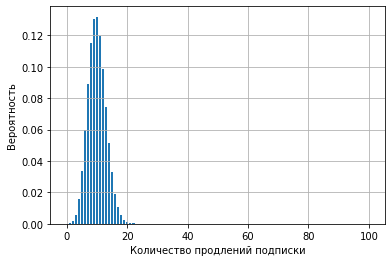

Минимальное количество промокодов для вероятности не выполнения плана в 5.00%: 100


In [48]:
p = 0.1
target_prob = 0.05


N = 100
while True:
    prob = 1 - st.binom.cdf(100, N, p)
    if prob <= target_prob:
        break
    N += 1

x = np.arange(0, N + 1)
pmf = st.binom.pmf(x, N, p)
plt.bar(x, pmf)
plt.xlabel("Количество продлений подписки")
plt.ylabel("Вероятность")
plt.grid(True)
plt.show()
print('Минимальное количество промокодов для вероятности не выполнения плана в {:.2%}: {}'.format(target_prob, N))

Для того, чтобы достигнуть вероятности не выполнения плана примерно на 5%, необходимо разослать минимальное количество промокодов, равное 100. Это количество промокодов обеспечит достаточное количество пользователей, которые продлят подписку после бесплатного пробного периода.

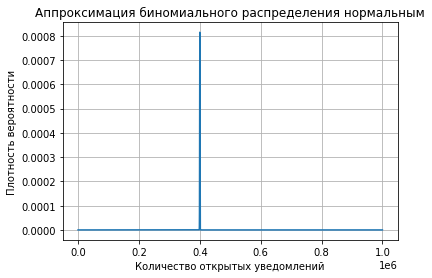

Вероятность открытия уведомления не более 399500 пользователей: 15.37%


In [49]:
n = 1000000  
p = 0.4  
target_opened = 399500

mean = n * p
std = np.sqrt(n * p * (1 - p))

prob = st.norm.cdf(target_opened, mean, std)

x = np.arange(0, n + 1)
pdf = st.norm.pdf(x, mean, std)
plt.plot(x, pdf)
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Плотность вероятности')
plt.title('Аппроксимация биномиального распределения нормальным')
plt.grid(True)
plt.show()

print('Вероятность открытия уведомления не более {} пользователей: {:.2%}'.format(target_opened, prob))



**Выводы**
Мы проанализировали датасеты, хранящие в себе данные о поездках на самокатах сервиса GoFast и пришли к следующим выводам:
1) Основаная целевая аудитория состоит из людей 22-30 лет.

2) Самокаты примерно одинаково популярны в разных городах.

3) В основном, на самокатах совершаются поездки на растояния 2.5-3.5 км.

4) Большинство пользователей предпочитает пользоваться бесплатным тарифом, однако средняя длительность поездки лишь на 1 минуту меньше, чем у пользователей с подпиский (17.4 и 18.5 минут соответственно). Тем не менее, пользователей с подпиской, которые тратят на поездку времея, близкое к среднему, больше при равных выборках.

5) Нулевой показатель P-value позволяет сделать вывод о том, что наблюдаемая разница в продолжительности поездок между пользователями с подпиской и без подписки является статистически значимой.

6) Среднее расстояние равно или превышает 3130 метров.

7) Помесячная выручка от пользователей с бесплатным тарифом и подпиской, примерно, равна.